In [304]:
import pandas as pd
import numpy as np
import matplotlib

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

In [305]:

# import the input data into a dataframe 
df = pd.read_csv('Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv')

In [306]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 60 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Order                                                       11746 non-null  int64  
 1   Property Id                                                 11746 non-null  int64  
 2   Property Name                                               11746 non-null  object 
 3   Parent Property Id                                          11746 non-null  object 
 4   Parent Property Name                                        11746 non-null  object 
 5   BBL - 10 digits                                             11735 non-null  object 
 6   NYC Borough, Block and Lot (BBL) self-reported              11746 non-null  object 
 7   NYC Building Identification Number (BIN)                    11746 non-null  object 
 

In [307]:
df.value_counts('ENERGY STAR Score')

ENERGY STAR Score
Not Available    2104
100               649
1                 299
99                162
80                144
                 ... 
17                 48
12                 47
42                 47
21                 46
11                 44
Length: 101, dtype: int64

In [308]:
#Information Summary of the given dataset
#We have 11746  rows/observations and total 60 features/columns.
#Certain features are numerical information like ENERGY STAR Score,  Site EUI (kBtu/ft²), etc, which should be

# Here, The target variable ENERGY STAR Score has range of values therefore we apply Regression  Models 

## Data Preprocessing

In [309]:
#First we drop irrelevant columns, For example few columns such as parents property id, address 2, 
# 2nd largest property use, etc.
# To understand the meaning of different features, we visited the following links 
# https://www.nyc.gov/html/gbee/downloads/misc/nyc_benchmarking_disclosure_data_definitions_2017.pdf
# Even though Energy star score, site EUI, Source EUI are quantitative measures, but they are represneted as 
# objects, thus we converted them as float

# Also Few object data types contains strings as Not Available, so we replace  Not Available with NA and find the 
# coloums which has maximum not available entry and which are irrelevant

drop_list=['Property Name', 'Parent Property Name', 'BBL - 10 digits',
 'NYC Borough, Block and Lot (BBL) self-reported', 'NYC Building Identification Number (BIN)', 
 'Address 1 (self-reported)', 'Address 2', 'Postal Code', 'Street Number',
 'Street Name', 'List of All Property Use Types at Property', 
 'Largest Property Use Type', 'Largest Property Use Type - Gross Floor Area (ft²)',
 '2nd Largest Property Use Type',
 '2nd Largest Property Use - Gross Floor Area (ft²)', '3rd Largest Property Use Type',
 '3rd Largest Property Use Type - Gross Floor Area (ft²)', 'Water Use (All Water Sources) (kgal)',
 'Release Date', 'Latitude', 'Longitude', 'Community Board', 'Council District', 'Census Tract', 'NTA']
df.drop(columns=drop_list, inplace= True, axis=1)

In [310]:
# Restrict the focus to standalone properties as data for campus properties are of poor quality
df=df[df['Parent Property Id'] == 'Not Applicable: Standalone Property']
df.head()

,Order,Property Id,Parent Property Id,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),...,Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Water Required?,DOF Benchmarking Submission Status
422,448,1261451,Not Applicable: Standalone Property,Manhattan,2542563.0,Office,1970,1,100,Whole Building,...,116307222.2,3.51915945E7,19319.9,2602.6,16717.4,2428325,20.56,215.8,Yes,In Compliance
423,449,4292967,Not Applicable: Standalone Property,Manhattan,1016406.0,Office,1969,1,95,Whole Building,...,60067921.6,1.76048987E7,6614.7,0,6614.7,1096193,Not Available,189.3,Yes,In Compliance
424,450,2712342,Not Applicable: Standalone Property,Manhattan,1354691.0,Office,1970,1,100,Whole Building,...,62199391.9,1.82295968E7,Not Available,0,Not Available,1390556,22.05,225,Yes,In Compliance
425,452,2792771,Not Applicable: Standalone Property,Manhattan,169061.0,Multifamily Housing,1985,1,100,Whole Building,...,7660120,2203943.6,1652.4,941.5,710.9,169055,Not Available,222.2,Yes,In Compliance
426,453,2897761,Not Applicable: Standalone Property,Manhattan,845018.0,Office,1969,1,100,Whole Building,...,41724669.2,1.20844921E7,4911.4,0,4911.4,852840,14.06,175.7,No,In Compliance


In [311]:
# drop the 'Parent Property Id' column since all rows have the same value
df.drop(columns=['Parent Property Id'], inplace= True)
df.shape

(11324, 34)

In [312]:
#We replace not available values of columns with nan
df = df.replace({'Not Available': np.nan})

In [313]:
# Now we remove the records which doen't have  target value
df = df.dropna(axis=0, subset=['ENERGY STAR Score'])

In [314]:
df.duplicated().sum().any()

False

In [315]:
#First we will check any missing data
df.isnull().sum()
percent_missing=df.isnull().sum()*100/len(df)
percent_missing

Order                                                          0.000000
Property Id                                                    0.000000
Borough                                                        0.159473
DOF Gross Floor Area                                           0.159473
Primary Property Type - Self Selected                          0.000000
Year Built                                                     0.000000
Number of Buildings - Self-reported                            0.000000
Occupancy                                                      0.000000
Metered Areas (Energy)                                         0.031895
Metered Areas  (Water)                                        38.273442
ENERGY STAR Score                                              0.000000
Site EUI (kBtu/ft²)                                            0.000000
Weather Normalized Site EUI (kBtu/ft²)                        11.471401
Weather Normalized Site Electricity Intensity (kWh/ft²)        4

In [316]:
missing_perct_df=pd.DataFrame({"col_name":df.columns,"% missing":percent_missing})
# missing_perct_df.head(11)
missing_perct_df.sort_values(by="% missing",ascending=False)

,col_name,% missing
Fuel Oil #1 Use (kBtu),Fuel Oil #1 Use (kBtu),99.904316
Diesel #2 Use (kBtu),Diesel #2 Use (kBtu),99.883053
Fuel Oil #5 & 6 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),95.449713
District Steam Use (kBtu),District Steam Use (kBtu),92.100787
Fuel Oil #4 Use (kBtu),Fuel Oil #4 Use (kBtu),88.401021
Fuel Oil #2 Use (kBtu),Fuel Oil #2 Use (kBtu),77.556879
Metered Areas (Water),Metered Areas (Water),38.273442
Water Intensity (All Water Sources) (gal/ft²),Water Intensity (All Water Sources) (gal/ft²),31.756326
Weather Normalized Site Natural Gas Use (therms),Weather Normalized Site Natural Gas Use (therms),14.639592
Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Site Natural Gas Intensity ...,14.639592


In [317]:
# Since many coloumns contains null values thus we  identify and discard columns having >25% null values
#thus column to be removed we will place in list
col_rem = []
for col in df.columns:
    if df[col].isna().sum()/len(df) > 0.25:
        col_rem.append(col)
print(col_rem)        
df.drop(columns=col_rem, inplace= True, axis=1)


['Metered Areas  (Water)', 'Fuel Oil #1 Use (kBtu)', 'Fuel Oil #2 Use (kBtu)', 'Fuel Oil #4 Use (kBtu)', 'Fuel Oil #5 & 6 Use (kBtu)', 'Diesel #2 Use (kBtu)', 'District Steam Use (kBtu)', 'Water Intensity (All Water Sources) (gal/ft²)']


In [318]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9406 entries, 422 to 11745
Data columns (total 26 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Order                                                       9406 non-null   int64  
 1   Property Id                                                 9406 non-null   int64  
 2   Borough                                                     9391 non-null   object 
 3   DOF Gross Floor Area                                        9391 non-null   float64
 4   Primary Property Type - Self Selected                       9406 non-null   object 
 5   Year Built                                                  9406 non-null   int64  
 6   Number of Buildings - Self-reported                         9406 non-null   int64  
 7   Occupancy                                                   9406 non-null   int64  


In [319]:
# Two GFA columns are available; examine the difference between those and eliminate one of them
diffGFA = (abs(df['DOF Gross Floor Area'] - df['Property GFA - Self-Reported (ft²)'])) / df['DOF Gross Floor Area'] *100

In [320]:
# From the describe we know that the difference between data is less so we can drop any one of them 
diffGFA.describe()

count    9391.000000
mean        8.428241
std        19.390945
min         0.000000
25%         0.000000
50%         3.487693
75%        11.117052
max      1067.070437
dtype: float64

In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9406 entries, 422 to 11745
Data columns (total 26 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Order                                                       9406 non-null   int64  
 1   Property Id                                                 9406 non-null   int64  
 2   Borough                                                     9391 non-null   object 
 3   DOF Gross Floor Area                                        9391 non-null   float64
 4   Primary Property Type - Self Selected                       9406 non-null   object 
 5   Year Built                                                  9406 non-null   int64  
 6   Number of Buildings - Self-reported                         9406 non-null   int64  
 7   Occupancy                                                   9406 non-null   int64  


In [322]:
## Checking for Outliers

In [323]:
# Since we wnat to evaluate Energy consumptoin on per squarefeet area, thus we need
# to make sure that every entry of GFA should be present
df.isna().sum()

Order                                                            0
Property Id                                                      0
Borough                                                         15
DOF Gross Floor Area                                            15
Primary Property Type - Self Selected                            0
Year Built                                                       0
Number of Buildings - Self-reported                              0
Occupancy                                                        0
Metered Areas (Energy)                                           3
ENERGY STAR Score                                                0
Site EUI (kBtu/ft²)                                              0
Weather Normalized Site EUI (kBtu/ft²)                        1079
Weather Normalized Site Electricity Intensity (kWh/ft²)        458
Weather Normalized Site Natural Gas Intensity (therms/ft²)    1377
Weather Normalized Source EUI (kBtu/ft²)                      

In [324]:
# Fill null values of 'DOF Gross Floor Area' with values from 'Property GFA - Self-Reported (ft_)'
df['DOF Gross Floor Area'].mask(cond=df['DOF Gross Floor Area'].isna(), 
           other=df['Property GFA - Self-Reported (ft²)'], axis=0, inplace=True)
# df.drop(columns=['Property GFA - Self-Reported (ft²)'], axis=1, inplace= True)

In [325]:
# Verify if the NaNs have been dealt with
df['DOF Gross Floor Area'].isna().sum()

0

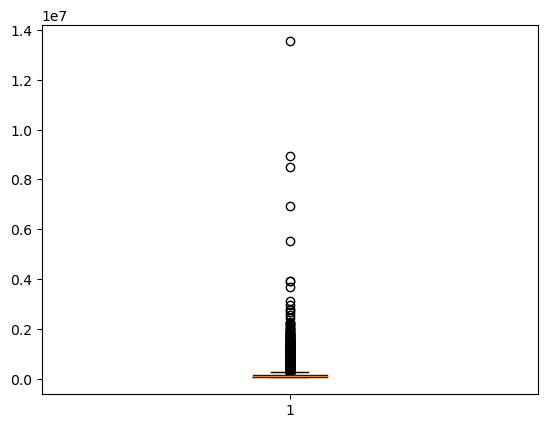

In [326]:
# we plot box plot to find outliers if any 
plt.boxplot(df['DOF Gross Floor Area'])
plt.show()

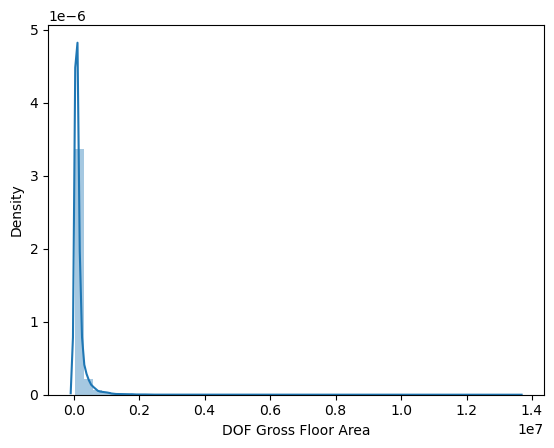

In [327]:
# distribution plot confirms the same as boxplot
ax = sns.distplot(df['DOF Gross Floor Area'])

In [328]:
# find out the no. of records having GFA >0.3e7 (outliers)
df[df['DOF Gross Floor Area'] > 0.3e7]

,Order,Property Id,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),ENERGY STAR Score,...,Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Source EUI (kBtu/ft²),Water Required?,DOF Benchmarking Submission Status
510,550,2481300,Manhattan,3678000.0,Office,1972,1,100,Whole Building,77,...,NaN,256865235.1,7.45061831E7,32950.5,0,32950.5,3636683,267.2,No,In Compliance
2266,2651,4157757,Manhattan,8942176.0,Multifamily Housing,1947,35,100,Whole Building,82,...,266785.8,166404374.5,4.71706417E7,38755.9,1399,37356.8,8942176,105.9,No,In Compliance
2267,2652,4157734,Manhattan,3122165.0,Multifamily Housing,1947,21,100,Whole Building,90,...,67577.8,46199678.1,1.31210486E7,11649.9,352.3,11297.5,3122165,89.4,No,In Compliance
6880,8277,2775816,Bronx,8512479.0,Multifamily Housing,1941,1,100,Whole Building,48,...,NaN,47879332.9,NaN,16873,12429.8,4443.2,2920848,134.4,No,In Compliance
6885,8281,3584061,Bronx,3911254.0,Multifamily Housing,1940,1,100,Whole Building,1,...,281235.8,57290935.7,NaN,6810.4,1493.8,5316.6,3312,63231.7,Yes,In Compliance
6888,8286,2740271,Bronx,3911254.0,Multifamily Housing,1940,1,100,Whole Building,99,...,4932.7,1546336.7,442826,417,26.2,390.8,131237,75.1,Yes,In Compliance
7153,8623,3334926,Bronx,5541031.0,Multifamily Housing,1969,1,100,Whole Building,100,...,1261779.9,7026457.1,2059336.5,9083,8430.9,652.1,5818083,30.6,Yes,In Compliance
7158,8630,3334927,Bronx,13540113.0,Multifamily Housing,1969,1,100,Whole Building,100,...,3083296.3,17169913.6,5032213.2,22195.2,20601.9,1593.4,14217119,30.6,No,In Compliance
11481,14519,4335594,Queens,6940450.0,Multifamily Housing,1962,28,100,Whole Building,10,...,1.04834443E7,NaN,NaN,63451.1,63451.1,0,6940450,173.8,Yes,In Compliance


In [329]:
# remove the outliers based on GFA > 0.3e7
df = df[df['DOF Gross Floor Area'] < 0.3e7]

In [330]:
df.shape

(9397, 26)

In [331]:
#Now we fixed the numeric data as correct data type as float
for col in list(df.columns):
# Select all those columns in the dataset which  should be numeric
    if ('ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in 
        col or 'therms' in col or 'gal' in col or 'Score' in col):
         df[col] = df[col].astype(float)

In [332]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9397 entries, 422 to 11745
Data columns (total 26 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Order                                                       9397 non-null   int64  
 1   Property Id                                                 9397 non-null   int64  
 2   Borough                                                     9382 non-null   object 
 3   DOF Gross Floor Area                                        9397 non-null   float64
 4   Primary Property Type - Self Selected                       9397 non-null   object 
 5   Year Built                                                  9397 non-null   int64  
 6   Number of Buildings - Self-reported                         9397 non-null   int64  
 7   Occupancy                                                   9397 non-null   int64  


In [333]:
# Now we normalize all measurements with respect to DOF Gross Floor Area

In [334]:
# Normalize the non-normalized columns by dividing by GFA
df['Natural Gas Use (kBtu)_Norm'] = df['Natural Gas Use (kBtu)']/df['DOF Gross Floor Area']
df['Weather Normalized Site Natural Gas Use (therms)_Norm'] = df['Weather Normalized Site Natural Gas Use (therms)']/df['DOF Gross Floor Area']
df['Electricity Use - Grid Purchase (kBtu)_Norm'] = df['Electricity Use - Grid Purchase (kBtu)']/df['DOF Gross Floor Area']
df['Weather Normalized Site Electricity (kWh)_Norm'] = df['Weather Normalized Site Electricity (kWh)']/df['DOF Gross Floor Area']
df['Total GHG Emissions (Metric Tons CO2e)_Norm'] = df['Total GHG Emissions (Metric Tons CO2e)']/df['DOF Gross Floor Area']
df['Direct GHG Emissions (Metric Tons CO2e)_Norm'] = df['Direct GHG Emissions (Metric Tons CO2e)']/df['DOF Gross Floor Area']
df['Indirect GHG Emissions (Metric Tons CO2e)_Norm'] = df['Indirect GHG Emissions (Metric Tons CO2e)']/df['DOF Gross Floor Area']

In [335]:
# calculate the building age and use it instead of Year Built
df['Age'] = datetime.now().year - df['Year Built']

In [336]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9397 entries, 422 to 11745
Data columns (total 34 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Order                                                       9397 non-null   int64  
 1   Property Id                                                 9397 non-null   int64  
 2   Borough                                                     9382 non-null   object 
 3   DOF Gross Floor Area                                        9397 non-null   float64
 4   Primary Property Type - Self Selected                       9397 non-null   object 
 5   Year Built                                                  9397 non-null   int64  
 6   Number of Buildings - Self-reported                         9397 non-null   int64  
 7   Occupancy                                                   9397 non-null   int64  


In [337]:
#Identify all columns having numeric values
numeric_cols = ['Age', 'Number of Buildings - Self-reported', 'Occupancy', 
        'Site EUI (kBtu/ft²)', 'Weather Normalized Site EUI (kBtu/ft²)', 'Weather Normalized Site Electricity Intensity (kWh/ft²)',
        'Weather Normalized Site Natural Gas Intensity (therms/ft²)', 'Weather Normalized Source EUI (kBtu/ft²)',
        'Natural Gas Use (kBtu)_Norm', 'Weather Normalized Site Natural Gas Use (therms)_Norm',
        'Electricity Use - Grid Purchase (kBtu)_Norm', 'Weather Normalized Site Electricity (kWh)_Norm',
        'Total GHG Emissions (Metric Tons CO2e)_Norm', 'Direct GHG Emissions (Metric Tons CO2e)_Norm',
        'Indirect GHG Emissions (Metric Tons CO2e)_Norm', 'Source EUI (kBtu/ft²)']

In [338]:
#Remove the columns which have been converted into normalized counterparts
cols_to_be_dropped = ['Year Built', 'Natural Gas Use (kBtu)', 'Weather Normalized Site Natural Gas Use (therms)',
    'Electricity Use - Grid Purchase (kBtu)', 'Weather Normalized Site Electricity (kWh)', 
    'Total GHG Emissions (Metric Tons CO2e)', 'Direct GHG Emissions (Metric Tons CO2e)',
    'Indirect GHG Emissions (Metric Tons CO2e)', 'DOF Benchmarking Submission Status']

In [339]:
df = df.drop(columns=cols_to_be_dropped)

In [340]:
# Now we detect outliers and remove them 
def outlier_detect(df):
    outlier = pd.DataFrame()
    for col in df.columns:
        first_quartile = df[col].quantile(q=0.25)
        third_quartile = df[col].quantile(q=0.75)
        inter_quartile = third_quartile - first_quartile
        lower_limit = first_quartile - 5* inter_quartile
        upper_limit = third_quartile + 5* inter_quartile
        outlier.at['lower_limit', col] = lower_limit
        outlier.at['upper_limit', col] = upper_limit
        no_of_outliers = len(df[(df[col] < lower_limit) | (df[col] > upper_limit)])
        outlier.at['#outliers', col] = no_of_outliers
    return outlier

In [341]:
# call the function to get the lower limit, upper limit and estimated no. of outliers for each column
outlier_data = outlier_detect(df[numeric_cols])

In [342]:
outlier_data

,Age,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Natural Gas Use (kBtu)_Norm,Weather Normalized Site Natural Gas Use (therms)_Norm,Electricity Use - Grid Purchase (kBtu)_Norm,Weather Normalized Site Electricity (kWh)_Norm,Total GHG Emissions (Metric Tons CO2e)_Norm,Direct GHG Emissions (Metric Tons CO2e)_Norm,Indirect GHG Emissions (Metric Tons CO2e)_Norm,Source EUI (kBtu/ft²)
lower_limit,-132.0,1.0,100.0,-105.1,-109.7,-20.7,-2.9,-197.0,-285.333423,-3.074530,-66.074167,-19.440087,-0.007904,-0.011136,-0.007333,-195.5
upper_limit,286.0,1.0,100.0,265.6,278.6,33.2,3.7,466.3,365.528529,3.928211,109.402873,31.944423,0.019100,0.017258,0.011593,455.7
#outliers,2.0,286.0,693.0,97.0,69.0,90.0,16.0,103.0,17.000000,12.000000,103.000000,99.000000,97.000000,29.000000,123.000000,127.0


In [343]:
# prepare a list of columns for which outliers need to be removed (some columns have been skipped from numeric_cols)
outlier_cols = ['Site EUI (kBtu/ft²)', 'Weather Normalized Site EUI (kBtu/ft²)', 'Weather Normalized Site Electricity Intensity (kWh/ft²)',
         'Weather Normalized Site Natural Gas Intensity (therms/ft²)', 'Weather Normalized Source EUI (kBtu/ft²)',
        'Natural Gas Use (kBtu)_Norm', 'Weather Normalized Site Natural Gas Use (therms)_Norm',
        'Electricity Use - Grid Purchase (kBtu)_Norm', 'Weather Normalized Site Electricity (kWh)_Norm',
        'Total GHG Emissions (Metric Tons CO2e)_Norm', 'Direct GHG Emissions (Metric Tons CO2e)_Norm',
        'Indirect GHG Emissions (Metric Tons CO2e)_Norm', 'Source EUI (kBtu/ft²)']

In [344]:
# remove the outliers for each column
for col in outlier_cols:
    df.drop(index = df[(df[col] < outlier_data.at['lower_limit', col])
                | (df[col] > outlier_data.at['upper_limit', col])].index, inplace=True)

In [345]:
# row count after outliers have been removed
len(df)

9188

In [346]:
# Remove the columns whose variance is low (VARIANCE THRESHOLD METHOD)
df.drop(columns='Metered Areas (Energy)', inplace=True)

In [347]:
# Remove redundant columns
df.drop(columns=['Direct GHG Emissions (Metric Tons CO2e)_Norm', 
            'Indirect GHG Emissions (Metric Tons CO2e)_Norm'], inplace=True)

## Exploratory Data Analysis

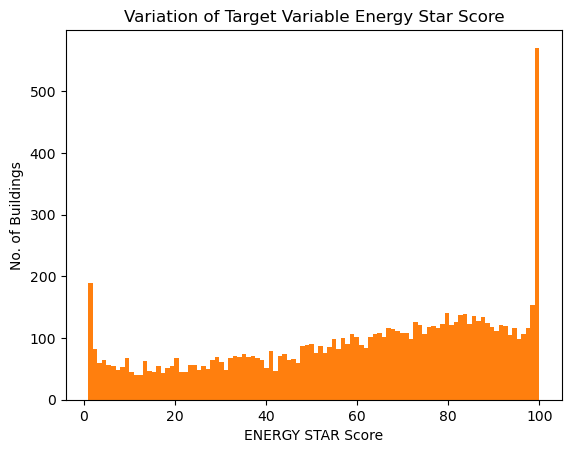

In [363]:
# study the distribution of the target variable
plt.hist(df['ENERGY STAR Score'], bins=10, density=True)
# Histogram of Energy Star Scores with 100 bins
plt.hist(df['ENERGY STAR Score'].dropna(), bins = 100);
plt.xlabel('ENERGY STAR Score'); plt.ylabel('No. of Buildings'); 
plt.title('Variation of Target Variable Energy Star Score');

##### Graph indicates energy star score varies between 1 to 100 and only for few buildings its value is 100  

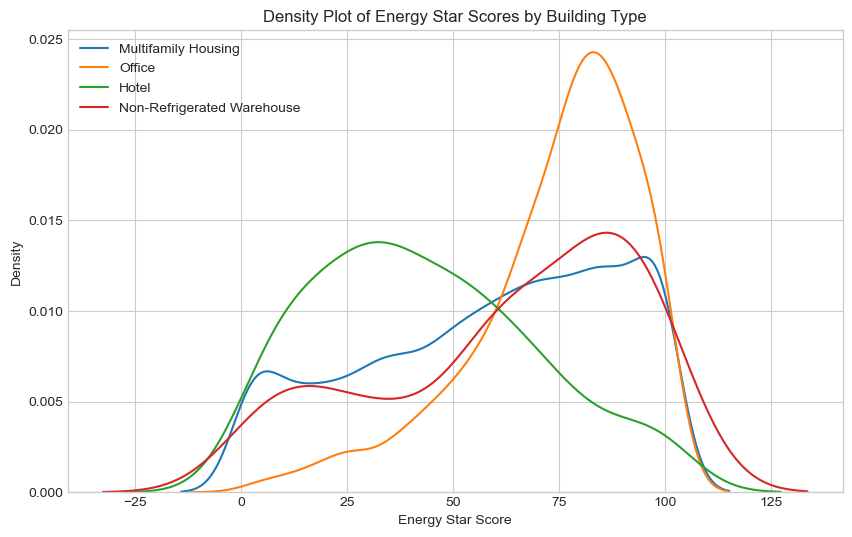

In [364]:
# Now we will check which types of bioldings has higher Energy Star Score
df1= df['Primary Property Type - Self Selected'].value_counts()
# Now we explore the distribution of Energy Star Scores for Different building types
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,6))
# Plotting density graph for buildings with frquency more than 200
for buildings in list(df1[df1.values>100].index):
    # Select the building type
    subset = df[df['Primary Property Type - Self Selected'] == buildings]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['ENERGY STAR Score'].dropna(),
               label = buildings, shade = False);
    
# label the plot
plt.legend()
plt.xlabel('Energy Star Score'); plt.ylabel('Density'); 
plt.title('Density Plot of Energy Star Scores by Building Type');

#### Graph indicates that office buildings have higher energy star score

In [350]:
# calculate the correlation coeff. between numeric features and target
# extract numeric features only for calculating correlation coefficient
df_numeric1 = df.select_dtypes(include='number')


In [212]:
# drop columns irrelevant for correlation calculation
df_numeric1.drop(columns=['Order', 'Property Id', 'DOF Gross Floor Area'], axis=1, inplace=True)
df_numeric1.head()

,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Property GFA - Self-Reported (ft²),Source EUI (kBtu/ft²),Natural Gas Use (kBtu)_Norm,Weather Normalized Site Natural Gas Use (therms)_Norm,Electricity Use - Grid Purchase (kBtu)_Norm,Weather Normalized Site Electricity (kWh)_Norm,Total GHG Emissions (Metric Tons CO2e)_Norm,Age
422,1,100,84.0,104.8,105.9,14.5,0.2,220.4,2428325.0,215.8,19.271609,0.173496,45.744087,13.840992,0.007599,53
423,1,95,84.0,69.1,70.6,16.1,NaN,191.1,1096193.0,189.3,NaN,NaN,59.098354,17.320735,0.006508,54
424,1,100,77.0,124.3,123.4,13.1,NaN,224.5,1390556.0,225.0,NaN,NaN,45.914081,13.456646,NaN,53
425,1,100,1.0,124.0,128.5,13.0,0.1,225.0,169055.0,222.2,12.758099,0.131253,45.309799,13.036381,0.009774,38
426,1,100,88.0,67.3,69.5,14.2,NaN,177.2,852840.0,175.7,NaN,NaN,49.377255,14.300869,0.005812,54


In [213]:
df_numeric1.shape

(9188, 16)

In [214]:
#calculate the pearson correlation coefficient between features and target
df_numeric1.corr(method='pearson')['ENERGY STAR Score'].sort_values()

Site EUI (kBtu/ft²)                                          -0.716174
Weather Normalized Site EUI (kBtu/ft²)                       -0.706193
Weather Normalized Source EUI (kBtu/ft²)                     -0.661553
Source EUI (kBtu/ft²)                                        -0.655616
Total GHG Emissions (Metric Tons CO2e)_Norm                  -0.619936
Weather Normalized Site Electricity Intensity (kWh/ft²)      -0.359166
Weather Normalized Site Natural Gas Intensity (therms/ft²)   -0.344304
Natural Gas Use (kBtu)_Norm                                  -0.317073
Electricity Use - Grid Purchase (kBtu)_Norm                  -0.309235
Weather Normalized Site Electricity (kWh)_Norm               -0.306300
Weather Normalized Site Natural Gas Use (therms)_Norm        -0.302900
Occupancy                                                    -0.033155
Number of Buildings - Self-reported                          -0.021783
Property GFA - Self-Reported (ft²)                            0.022239
Age   

In [215]:
#calculate the pearson correlation coefficient between features and target
correlation = df_numeric1.corr(method='spearman')['ENERGY STAR Score'].sort_values()
print

<function print>

In [216]:
# Select features based on a threshold
threshold = 0.4
correlation = correlation[correlation.abs() >= threshold]
print(correlation)

Site EUI (kBtu/ft²)                                       -0.756553
Source EUI (kBtu/ft²)                                     -0.751454
Weather Normalized Source EUI (kBtu/ft²)                  -0.749245
Weather Normalized Site EUI (kBtu/ft²)                    -0.741055
Total GHG Emissions (Metric Tons CO2e)_Norm               -0.662478
Weather Normalized Site Electricity Intensity (kWh/ft²)   -0.447751
Electricity Use - Grid Purchase (kBtu)_Norm               -0.411832
Weather Normalized Site Electricity (kWh)_Norm            -0.408980
ENERGY STAR Score                                          1.000000
Name: ENERGY STAR Score, dtype: float64


In [217]:
# select only those columns having correlation > threshold
df_numeric2=df_numeric1[correlation.index]

In [218]:
# Now we select Target variable
numeric_features = correlation.drop(index='ENERGY STAR Score').index

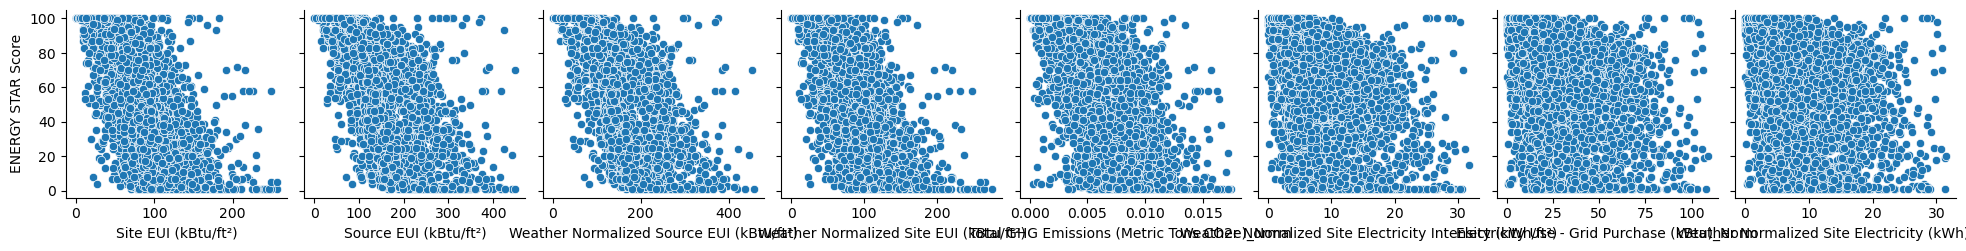

In [219]:
# study the relationships between each feature and target to determine if any transformation is needed
sns.pairplot(data=df_numeric2, x_vars = numeric_features, y_vars='ENERGY STAR Score')

In [ ]:
#Graph indicates that energy star score exhibits
# negative correlation with the other variables like Site EUI, Source EUI, etc.

<AxesSubplot: xlabel='Total GHG Emissions (Metric Tons CO2e)_Norm', ylabel='ENERGY STAR Score'>

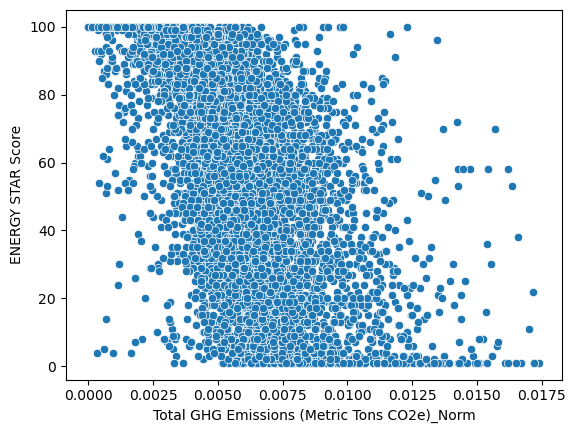

In [220]:
sns.scatterplot(x='Total GHG Emissions (Metric Tons CO2e)_Norm', y='ENERGY STAR Score', data=df_numeric2)

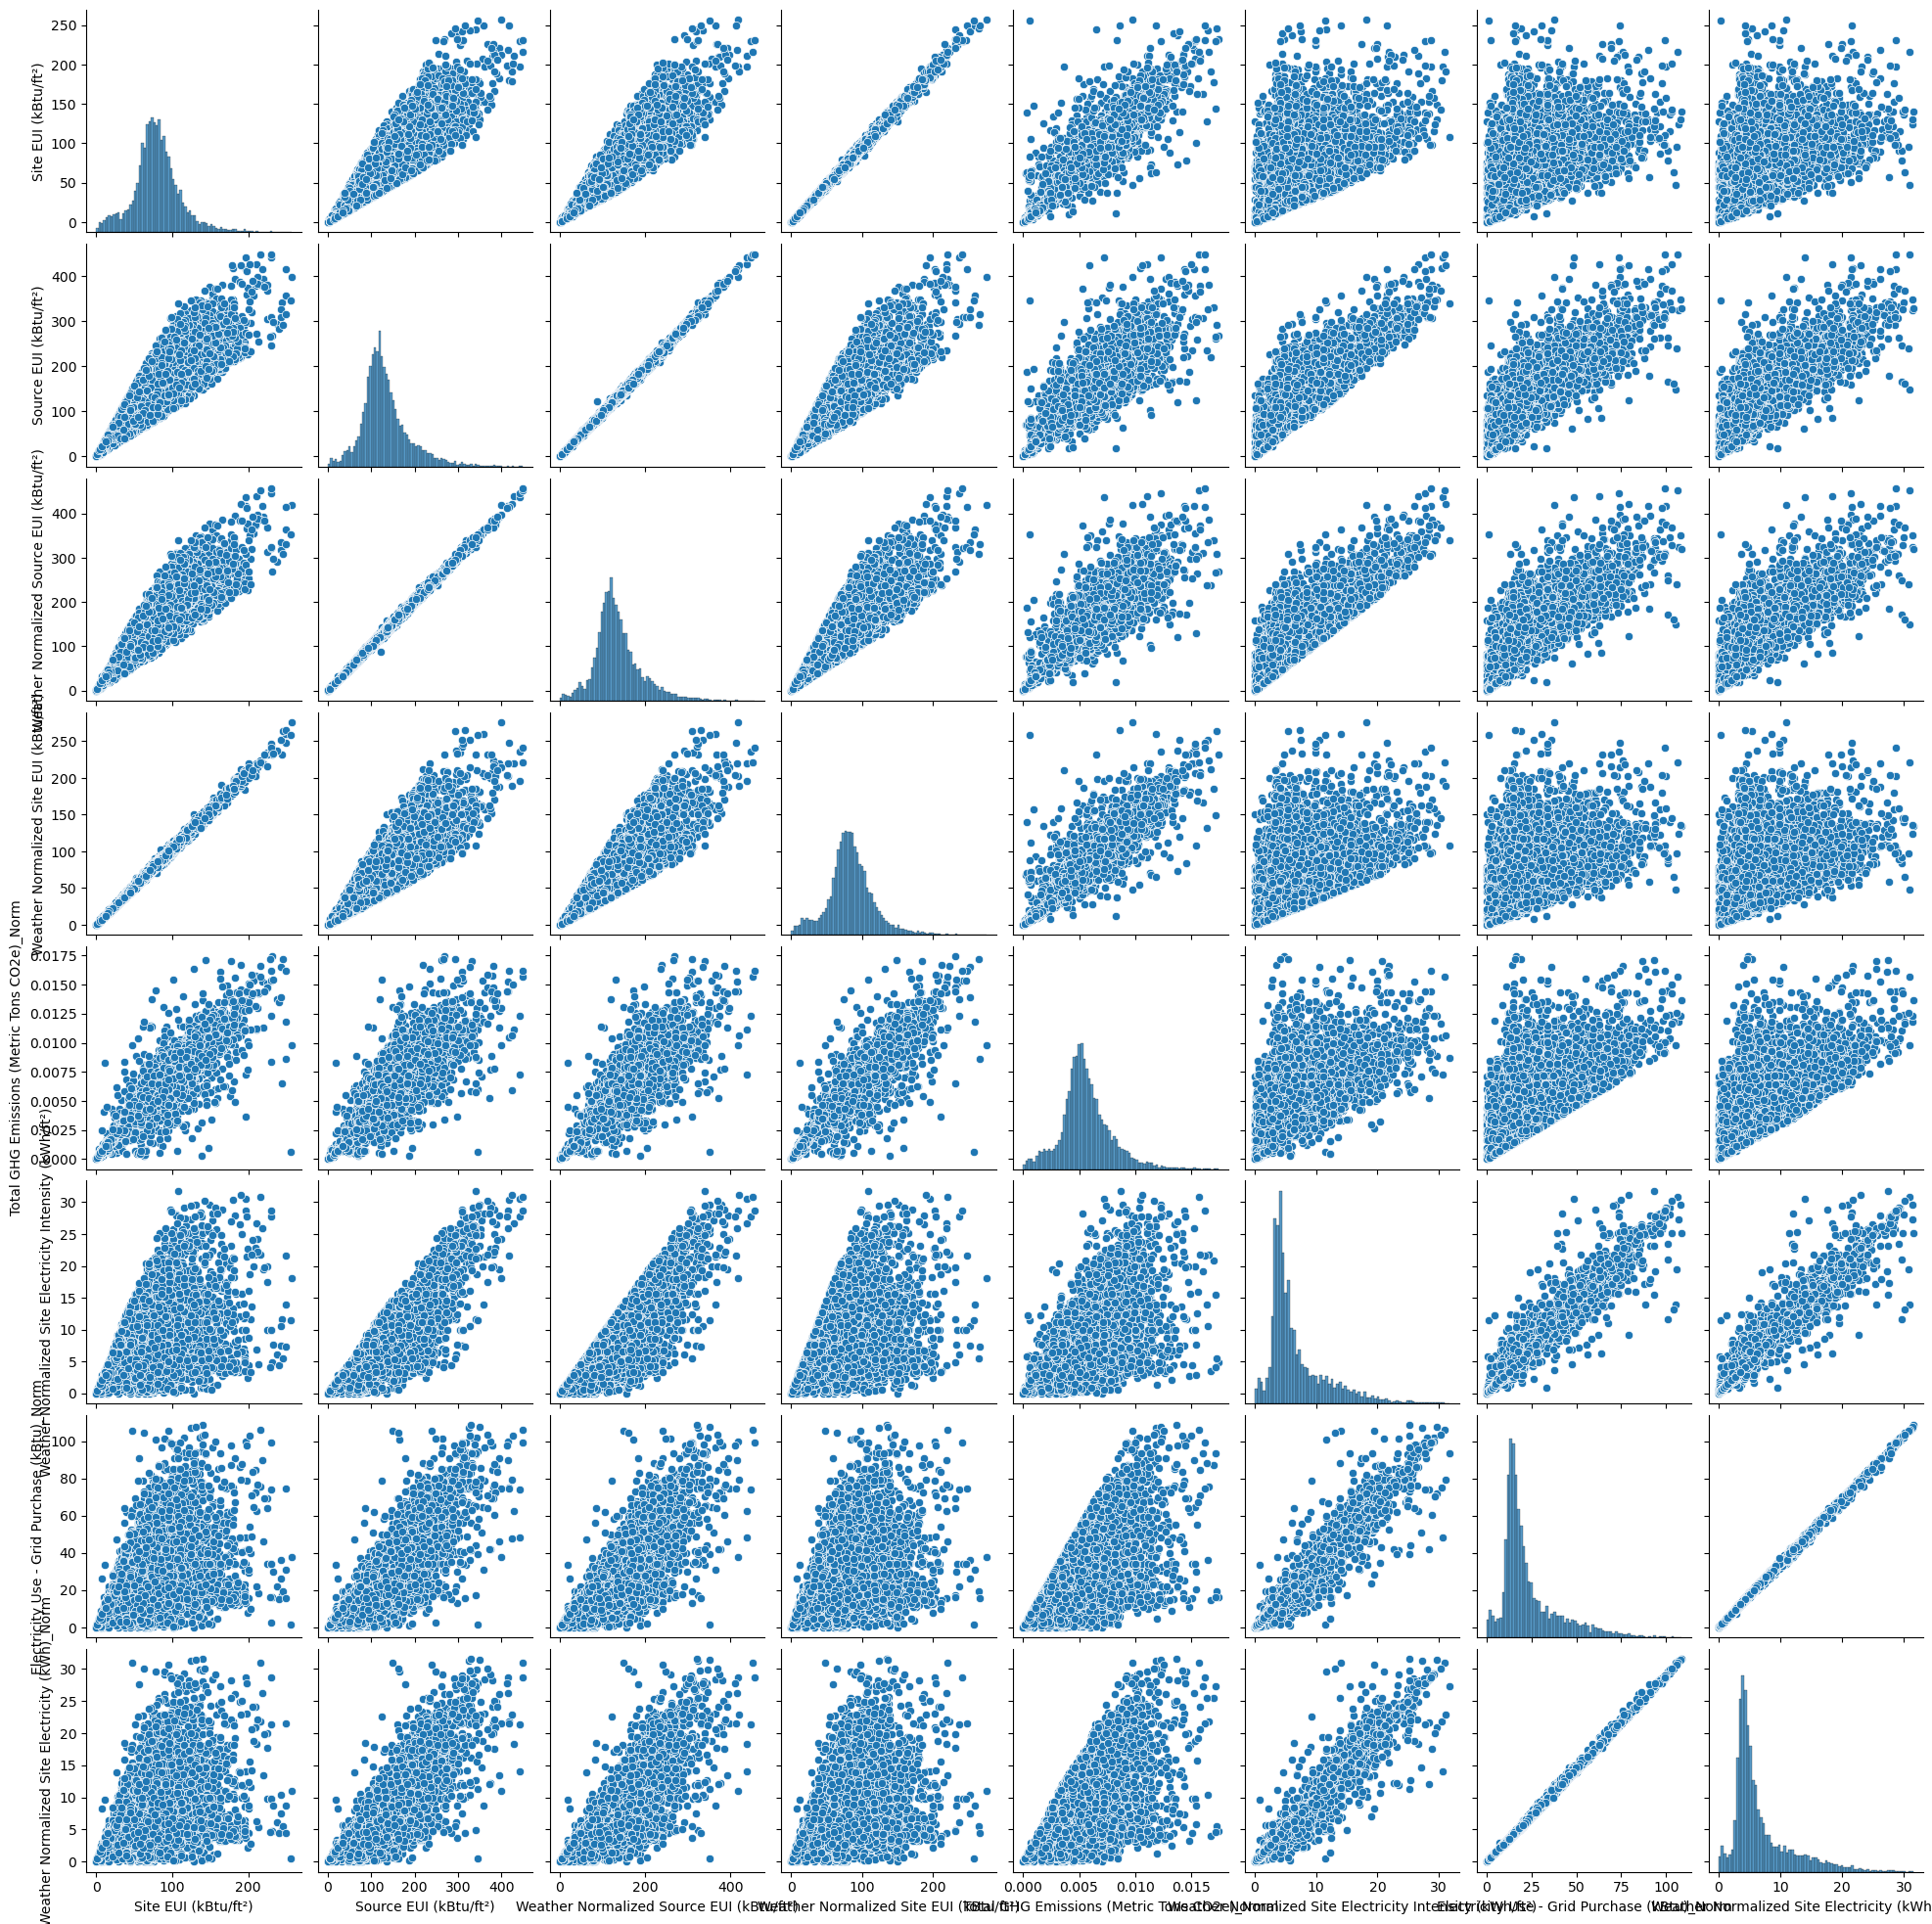

In [221]:
# study the relationship between features to check for collinearity
sns.pairplot(data = df_numeric2.drop(columns='ENERGY STAR Score'))

In [222]:
# dropping the features based on multi-collinearity analysis
df_numeric3 = df_numeric2.drop(columns=['Weather Normalized Site EUI (kBtu/ft²)', 'Weather Normalized Source EUI (kBtu/ft²)',
                        'Weather Normalized Site Electricity (kWh)_Norm'])

In [355]:
df_numeric3.columns

Index(['Site EUI (kBtu/ft²)', 'Source EUI (kBtu/ft²)',
       'Total GHG Emissions (Metric Tons CO2e)_Norm',
       'Weather Normalized Site Electricity Intensity (kWh/ft²)',
       'Electricity Use - Grid Purchase (kBtu)_Norm', 'ENERGY STAR Score'],
      dtype='object')

In [224]:
# find out the number of NaN in each column so that we know how many need to be imputed
for col in df_numeric3.columns:
    print(col, df_numeric3[col].isna().sum())

Site EUI (kBtu/ft²) 0
Source EUI (kBtu/ft²) 0
Total GHG Emissions (Metric Tons CO2e)_Norm 2
Weather Normalized Site Electricity Intensity (kWh/ft²) 438
Electricity Use - Grid Purchase (kBtu)_Norm 39
ENERGY STAR Score 0


In [356]:
df_numeric3.corr()

,Site EUI (kBtu/ft²),Source EUI (kBtu/ft²),Total GHG Emissions (Metric Tons CO2e)_Norm,Weather Normalized Site Electricity Intensity (kWh/ft²),Electricity Use - Grid Purchase (kBtu)_Norm,ENERGY STAR Score
Site EUI (kBtu/ft²),1.000000,0.809551,0.863515,0.331213,0.287128,-0.716174
Source EUI (kBtu/ft²),0.809551,1.000000,0.815102,0.822518,0.770563,-0.655616
Total GHG Emissions (Metric Tons CO2e)_Norm,0.863515,0.815102,1.000000,0.481812,0.528135,-0.619936
Weather Normalized Site Electricity Intensity (kWh/ft²),0.331213,0.822518,0.481812,1.000000,0.961363,-0.359166
Electricity Use - Grid Purchase (kBtu)_Norm,0.287128,0.770563,0.528135,0.961363,1.000000,-0.309235
ENERGY STAR Score,-0.716174,-0.655616,-0.619936,-0.359166,-0.309235,1.000000


In [225]:
# Extract the feature columns
X_numeric = df_numeric3.drop(columns=['ENERGY STAR Score'])

In [226]:
X_numeric.shape

(9188, 5)

In [230]:
numeric_feature_list = list(X_numeric.columns)


In [231]:
# Extract the target
y = df_numeric3['ENERGY STAR Score'].to_numpy(dtype='float64')

In [232]:
y.shape

(9188,)

## feature scaling

In [233]:
#We use min max scaler for feature scaling
scaler1 = MinMaxScaler().fit(X_numeric)

In [234]:
X_numeric_scaled = scaler1.transform(X_numeric)

In [235]:
np.savetxt('X_numeric_scaled.csv', X_numeric_scaled, fmt='%.8e', delimiter=',')

In [236]:
# impute missing values in the features
imputer = KNNImputer().fit(X_numeric_scaled)

In [237]:
X_imputed = imputer.transform(X_numeric_scaled)

In [238]:
# check if all the missing values have been imputed
np.isnan(X_imputed).sum()

0

In [239]:
np.savetxt('X_imputed.csv', X_imputed, fmt='%.8e', delimiter=',')
X_imputed.shape

(9188, 5)

In [240]:
# determine correlation between categorical features and target
# impute missing values
imputer1 = SimpleImputer(strategy="most_frequent").fit(df[['Borough', 'Primary Property Type - Self Selected']])

In [241]:
X_categorical = imputer1.transform(df[['Borough', 'Primary Property Type - Self Selected']])

In [242]:
print(type(X_categorical)); print(X_categorical.shape);

<class 'numpy.ndarray'>
(9188, 2)


In [243]:
# check if all missing values have been imputed
pd.isnull(X_categorical).sum()

0

In [244]:
# One Hot Encoding of the categorical features 'Borough' and 'Primary Property Type - Self Selected'
ohe = OneHotEncoder(sparse=False).fit(X_categorical)

In [245]:
ohe.categories_

[array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
       dtype=object),
 array(['College/University', 'Courthouse', 'Distribution Center',
        'Financial Office', 'Hospital (General Medical & Surgical)',
        'Hotel', 'K-12 School', 'Manufacturing/Industrial Plant',
        'Medical Office', 'Mixed Use Property', 'Multifamily Housing',
        'Non-Refrigerated Warehouse', 'Office', 'Other',
        'Refrigerated Warehouse', 'Residence Hall/Dormitory',
        'Residential Care Facility', 'Retail Store',
        'Self-Storage Facility', 'Senior Care Community',
        'Supermarket/Grocery Store', 'Wholesale Club/Supercenter',
        'Worship Facility'], dtype=object)]

In [246]:
# convert the ohe categories into a single list
cat_list1 = []; cat_list2 = [];
cat_list1 = [x for x in ohe.categories_[0]]
cat_list2 = [x for x in ohe.categories_[1]]
cat_list = cat_list1 + cat_list2
cat_list

['Bronx',
 'Brooklyn',
 'Manhattan',
 'Queens',
 'Staten Island',
 'College/University',
 'Courthouse',
 'Distribution Center',
 'Financial Office',
 'Hospital (General Medical & Surgical)',
 'Hotel',
 'K-12 School',
 'Manufacturing/Industrial Plant',
 'Medical Office',
 'Mixed Use Property',
 'Multifamily Housing',
 'Non-Refrigerated Warehouse',
 'Office',
 'Other',
 'Refrigerated Warehouse',
 'Residence Hall/Dormitory',
 'Residential Care Facility',
 'Retail Store',
 'Self-Storage Facility',
 'Senior Care Community',
 'Supermarket/Grocery Store',
 'Wholesale Club/Supercenter',
 'Worship Facility']

In [247]:
X_cat_encoded = ohe.transform(X_categorical)
print(type(X_cat_encoded)); print(X_cat_encoded.shape);

<class 'numpy.ndarray'>
(9188, 28)


In [248]:
# calculate the variance of each column in the encoded feature matrix
np.var(X_cat_encoded, axis=0)

array([1.46493676e-01, 1.64156357e-01, 2.43961147e-01, 1.47889564e-01,
       1.18288055e-02, 2.17627846e-04, 1.08825769e-04, 6.48761260e-03,
       1.19578044e-03, 1.30434560e-03, 2.06686752e-02, 8.20323835e-03,
       1.08825769e-04, 2.17201404e-03, 1.41288707e-03, 1.62811820e-01,
       1.55323998e-02, 1.03894340e-01, 3.25446736e-03, 9.78579033e-04,
       7.34618360e-03, 1.08825769e-04, 5.41226665e-03, 3.26406232e-04,
       9.16561256e-03, 5.43891931e-04, 3.26406232e-04, 1.08719158e-03])

In [249]:
# set variance threshold for eliminating features (VARIANCE THRESHOLD METHOD FOR FEATURE SELECTION)
threshold1 = 1e-02

In [250]:
index_to_retain = np.var(X_cat_encoded, axis=0) > threshold1

In [251]:
index_to_retain

array([ True,  True,  True,  True,  True, False, False, False, False,
       False,  True, False, False, False, False,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False])

In [252]:
X_cat_retained = X_cat_encoded[:, index_to_retain]

In [253]:

X_cat_retained.shape

(9188, 9)

In [254]:
# create a list index for the array index_to_retain
cat_index = []
cat_index = [i for i in index_to_retain]
cat_index

[True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [255]:
len(cat_index)

28

In [256]:
# Extract the list of categories selected
cat_list_retained = []
for i in range(len(cat_index)):
    if (cat_index[i] == True):
        cat_list_retained.append(cat_list[i])
cat_list_retained

['Bronx',
 'Brooklyn',
 'Manhattan',
 'Queens',
 'Staten Island',
 'Hotel',
 'Multifamily Housing',
 'Non-Refrigerated Warehouse',
 'Office']

In [257]:
# combine the numeric and categorical feature lists
feature_list = numeric_feature_list + cat_list_retained

In [258]:
feature_list

['Site EUI (kBtu/ft²)',
 'Source EUI (kBtu/ft²)',
 'Total GHG Emissions (Metric Tons CO2e)_Norm',
 'Weather Normalized Site Electricity Intensity (kWh/ft²)',
 'Electricity Use - Grid Purchase (kBtu)_Norm',
 'Bronx',
 'Brooklyn',
 'Manhattan',
 'Queens',
 'Staten Island',
 'Hotel',
 'Multifamily Housing',
 'Non-Refrigerated Warehouse',
 'Office']

In [259]:
# combine the numeric and categorical features to form the input array
X = np.hstack((X_imputed, X_cat_retained))

In [260]:
X.shape

(9188, 14)

In [261]:
# split the Feature and target arrays into train and test arrays
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [262]:
print(X_train.shape); print(X_test.shape); print(y_train.shape); print(y_test.shape);

(6891, 14)
(2297, 14)
(6891,)
(2297,)


In [263]:
# linear regression model
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
lm=LinearRegression()

lm.fit(X_train,y_train)

y_pred=lm.predict(X_test)
q=r2_score(y_test,y_pred)
print(f'r square value for train data is {q}')

print(f'rmse for train data is {sqrt(mean_squared_error(y_test,y_pred))}')

r square value for train data is 0.6206809685842588
rmse for train data is 17.818340710420163


In [264]:
from sklearn.neighbors import KNeighborsRegressor
knn=KNeighborsRegressor(n_neighbors=30)
knn.fit(X_train,y_train)
y_pred_knn=knn.predict(X_test)
print('r2 score is ', r2_score(y_test,y_pred_knn))

print('RMSE is', np.sqrt(mean_squared_error(y_test,y_pred_knn)))

r2 score is  0.7704037678704807
RMSE is 13.862683911285197


In [265]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn import metrics


In [266]:
# decision tree

dt=DecisionTreeRegressor(max_depth=5,min_samples_split=11)
dt.fit(X_train,y_train)
y_pred_dt=dt.predict(X_test)
print('r2 score is ', r2_score(y_test,y_pred_dt))

print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred_dt)))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_dt))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_dt))


r2 score is  0.7719620419148523
RMSE: 13.815560667369189
MAE: 9.84864866516179
MSE: 190.8697165537586


In [267]:
# random forest 

rf=RandomForestRegressor(random_state=60,max_depth=10,max_leaf_nodes=15,n_estimators=20)
rf.fit(X_train,y_train)
y_pred_rf=rf.predict(X_test)
print('r2 score is ', r2_score(y_test,y_pred_rf))

print('RMSE is', np.sqrt(mean_squared_error(y_test,y_pred_rf)))

r2 score is  0.7756519936335664
RMSE is 13.703327898078543


In [278]:
# svr

svr=SVR(kernel='rbf', C = 1000, gamma = 0.1)
svr.fit(X_train,y_train)
y_pred_svr=svr.predict(X_test)
print('r2 score is ', r2_score(y_test,y_pred_svr))

print('RMSE is', np.sqrt(mean_squared_error(y_test,y_pred_svr)))

r2 score is  0.7487860632201901
RMSE is 14.500627864348889


## Hyper Parameter Tuning


In [291]:
from sklearn.neighbors import KNeighborsRegressor
knn=KNeighborsRegressor(n_neighbors=35)
knn.fit(X_train,y_train)
y_pred_knn=knn.predict(X_test)
print('r2 score is ', r2_score(y_test,y_pred_knn))

print('RMSE is', np.sqrt(mean_squared_error(y_test,y_pred_knn)))

r2 score is  0.7671888017903071
RMSE is 13.959403972363427


In [369]:
# svr

svr=SVR(kernel='rbf', C = 1000, gamma = 0.2)
svr.fit(X_train,y_train)
y_pred_svr=svr.predict(X_test)
print('r2 score is ', r2_score(y_test,y_pred_svr))

print('RMSE is', np.sqrt(mean_squared_error(y_test,y_pred_svr)))

r2 score is  0.7729337798834325
RMSE is 13.78609312253177


## Model Evaluation

60.780964301262514


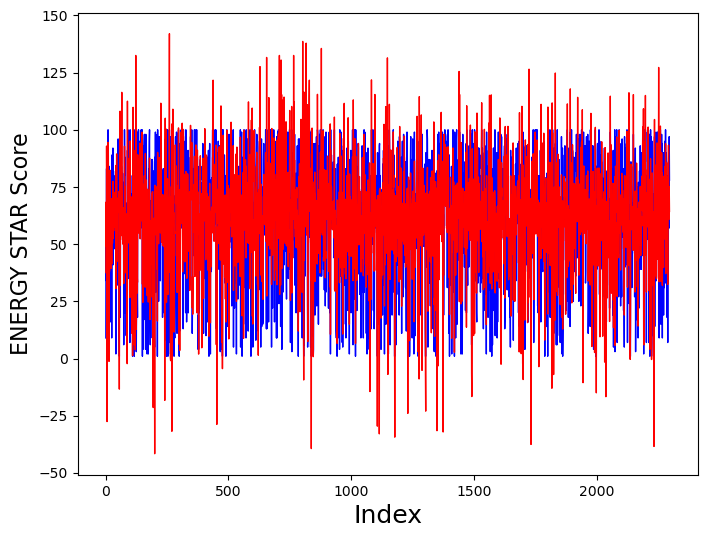

In [352]:
#Variation between Actual and Predicted Values
c = [i for i in range(1,2298,1)]
plt.figure(figsize= (8,6))
plt.plot(c,y_test, color="blue", linewidth=1, linestyle="-")     #Plotting Actual
plt.plot(c,y_pred, color="red",  linewidth=1, linestyle="-")  #Plotting predicted
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('ENERGY STAR Score', fontsize=16)                       # Y-label
print(y_pred.mean())

Text(0, 0.5, 'y_test-y_pred')

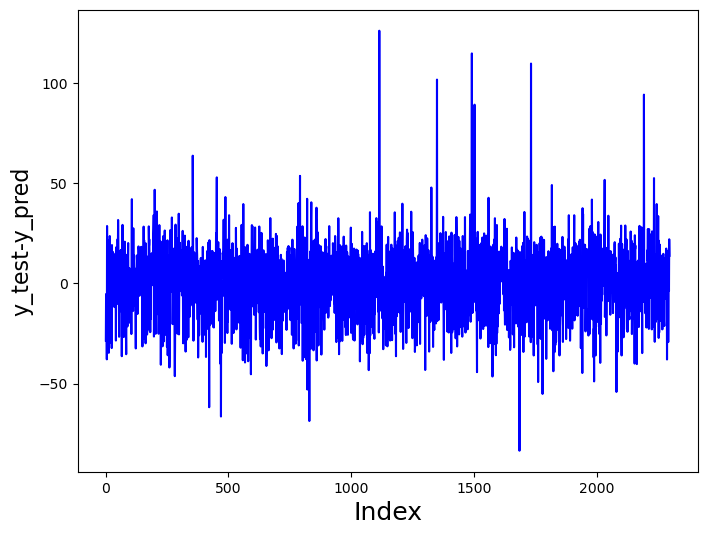

In [287]:
# Error terms for all 3 features
c = [i for i in range(1,2298,1)]
plt.figure(figsize= (8,6))

plt.plot(c,y_test-y_pred, color="blue", linewidth=1.5, linestyle="-")

fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('y_test-y_pred', fontsize=16)                # Y-label

## Inference and Conclusion

##### Q1 Does this dataset contain a set of independent variables that correlate to the energy star rating of the building?

In [ ]:
Ans. Yes dataset contain a set of five independent variables Site EUI (kBtu/ft²), Source EUI (kBtu/ft²),
       Total GHG Emissions (Metric Tons CO2e)_Norm,
       Weather Normalized Site Electricity Intensity (kWh/ft²),
       Electricity Use - Grid Purchase (kBtu)_Norm which correlate to the energy star 
rating of the building, these variables shows negative correlation with the
ENERGY STAR Score as shown below. 

In [359]:
df_numeric3.columns

Index(['Site EUI (kBtu/ft²)', 'Source EUI (kBtu/ft²)',
       'Total GHG Emissions (Metric Tons CO2e)_Norm',
       'Weather Normalized Site Electricity Intensity (kWh/ft²)',
       'Electricity Use - Grid Purchase (kBtu)_Norm', 'ENERGY STAR Score'],
      dtype='object')

In [361]:
df_numeric3.corr()

,Site EUI (kBtu/ft²),Source EUI (kBtu/ft²),Total GHG Emissions (Metric Tons CO2e)_Norm,Weather Normalized Site Electricity Intensity (kWh/ft²),Electricity Use - Grid Purchase (kBtu)_Norm,ENERGY STAR Score
Site EUI (kBtu/ft²),1.000000,0.809551,0.863515,0.331213,0.287128,-0.716174
Source EUI (kBtu/ft²),0.809551,1.000000,0.815102,0.822518,0.770563,-0.655616
Total GHG Emissions (Metric Tons CO2e)_Norm,0.863515,0.815102,1.000000,0.481812,0.528135,-0.619936
Weather Normalized Site Electricity Intensity (kWh/ft²),0.331213,0.822518,0.481812,1.000000,0.961363,-0.359166
Electricity Use - Grid Purchase (kBtu)_Norm,0.287128,0.770563,0.528135,0.961363,1.000000,-0.309235
ENERGY STAR Score,-0.716174,-0.655616,-0.619936,-0.359166,-0.309235,1.000000


<AxesSubplot: >

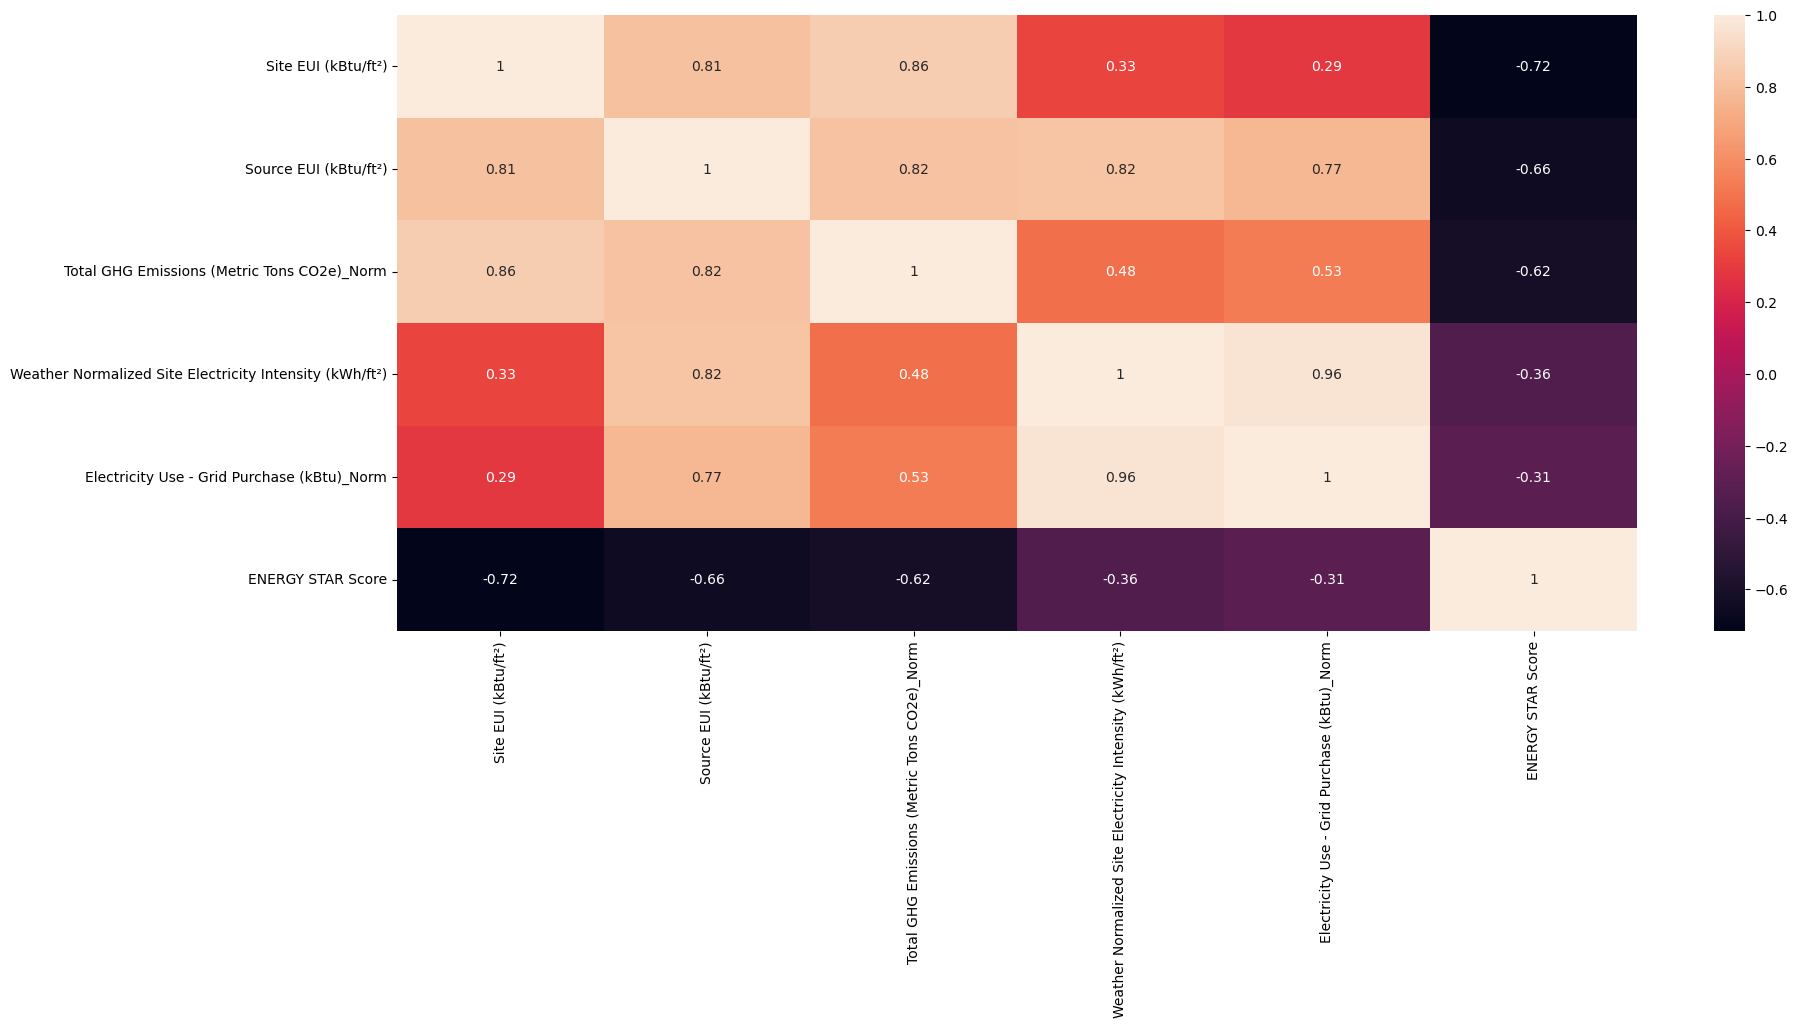

In [362]:
plt.figure(figsize=(20,8))
sns.heatmap(df_numeric3.corr(),annot=True)

##### Q.2 For buildings without energy star scores, can you infer what their score might be?

##### As shown in the above model evaluation graphs, for the buildings without energy star scores
the predicted score is approximately mean of y_pred = 60.780964301262514,  